# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-mhx6UJW0-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 70660.88 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 97705.66 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 119005.58 examples/s]

Filter (num_proc=6):  65%|██████▌   | 73061/112120 [00:00<00:00, 118641.81 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 151940.90 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 117846.88 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 73866.53 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 131013.70 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 139095.25 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 145021.25 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 151808.66 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 124824.61 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.13 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.17 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.99 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.47 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.35 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.32 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.26 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.96 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.26 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.36 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.16 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.91 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.84 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.42 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.29 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.61 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.54 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.96 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.79 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.02 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.05 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.39 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.19 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.77 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.65 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.33 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.28 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.55 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.13 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.16 examples/s]

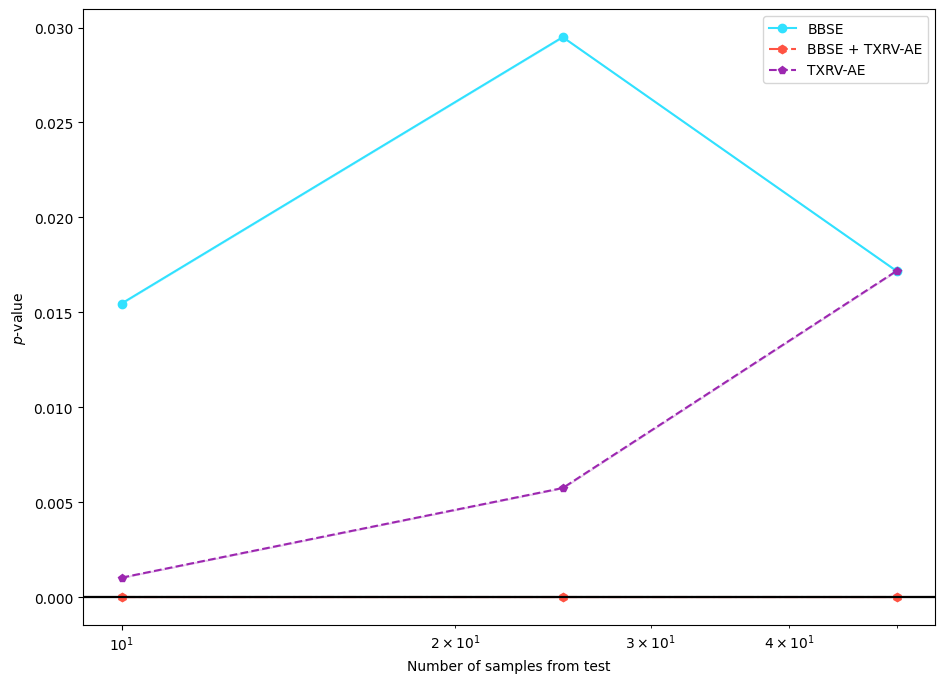

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.26 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.70 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.47 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.39 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.25 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.53 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.46 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.22 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.79 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.80 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.10 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.40 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.20 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.92 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.75 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.21 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.15 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.40 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.92 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.93 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.93 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.29 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.07 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.78 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.64 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.65 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.58 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.28 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.11 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.05 examples/s]

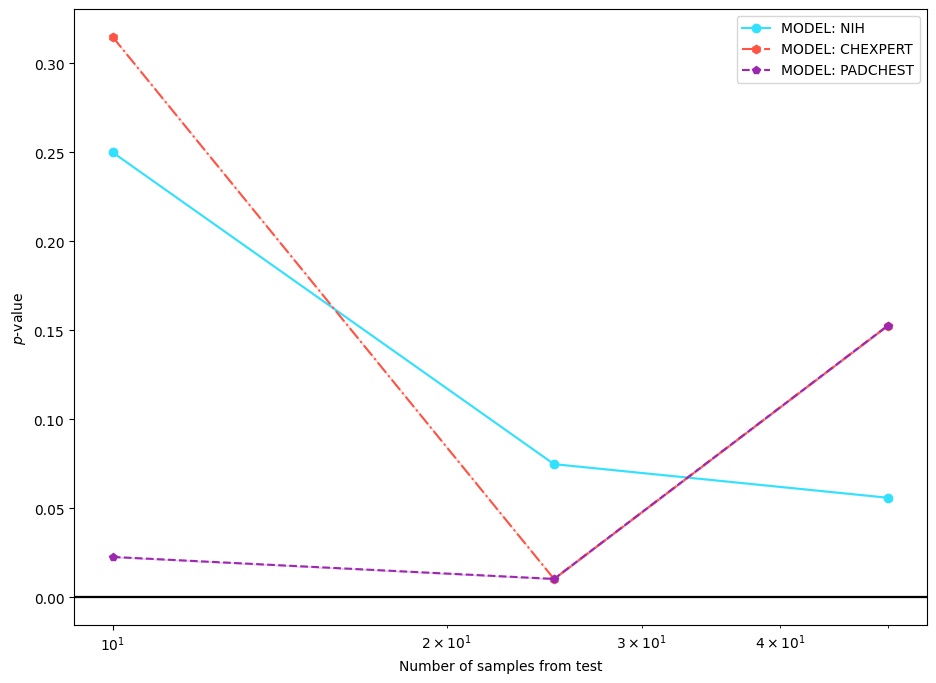

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53591.61 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 73011.29 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 86647.16 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 98916.77 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 102469.65 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109912.82 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 86434.45 examples/s] 

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55698.64 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77798.54 examples/s]

Filter (num_proc=6):  48%|████▊     | 54374/112120 [00:00<00:00, 82690.76 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 102478.09 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 104429.85 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 113659.27 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 88074.11 examples/s] 

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.71 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.02 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.80 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.10 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.96 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.52 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.46 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.66 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.60 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.51 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53579.30 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 71863.93 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 85225.92 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 91344.02 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 95039.70 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 96872.79 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 80137.24 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51927.19 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72645.97 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 84613.75 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 92369.13 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 97198.62 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 100436.35 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 81782.85 examples/s] 

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.98 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.13 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.98 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.54 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.40 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.47 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.40 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.59 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.99 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.08 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51266.04 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 71715.73 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 83394.11 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 91213.13 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 95235.16 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 98988.74 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 80430.94 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54607.95 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 76303.24 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 86550.50 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 92649.38 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 96204.49 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 99368.66 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 80286.36 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.27 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.88 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.59 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.69 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.55 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.77 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.70 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.06 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.76 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.76 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53629.23 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 74657.88 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 83892.18 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 92564.48 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 96672.75 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 99880.77 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 81454.19 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 50372.24 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72067.21 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 84224.36 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 91142.07 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 92836.63 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 100119.56 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 80332.12 examples/s] 

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.14 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.82 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.48 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.46 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.26 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.87 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.78 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.69 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.28 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.30 examples/s]

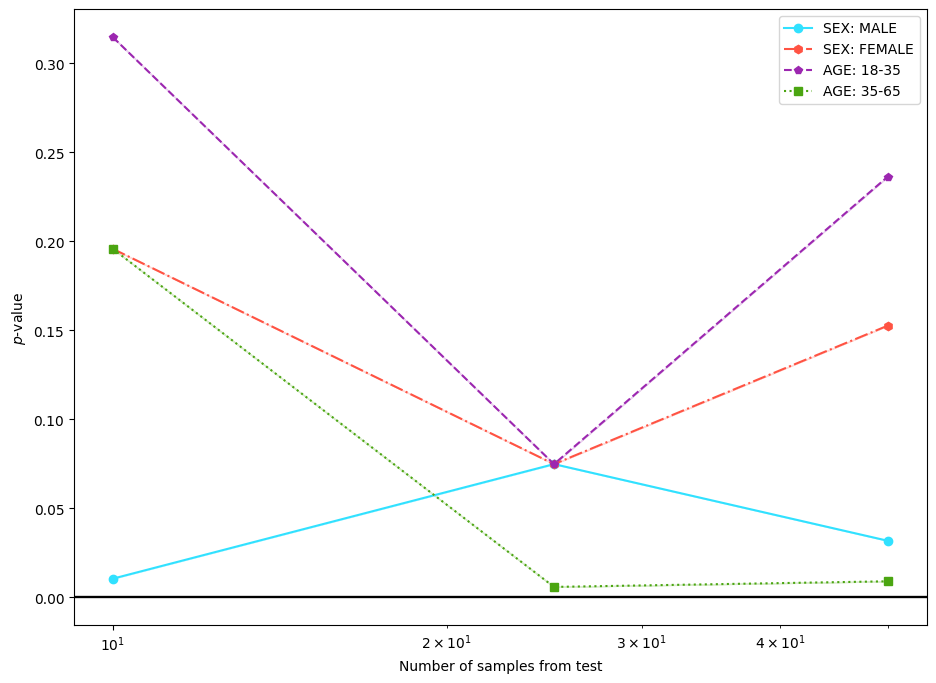

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.20 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.27 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.15 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.59 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.45 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 17.06 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.92 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.47 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.34 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.56 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.44 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.44 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.32 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.55 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.42 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.77 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.64 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 17.01 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.88 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.37 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.24 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 17.16 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 17.02 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.97 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.83 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.62 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.49 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 17.16 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 17.02 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.57 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.44 examples/s]

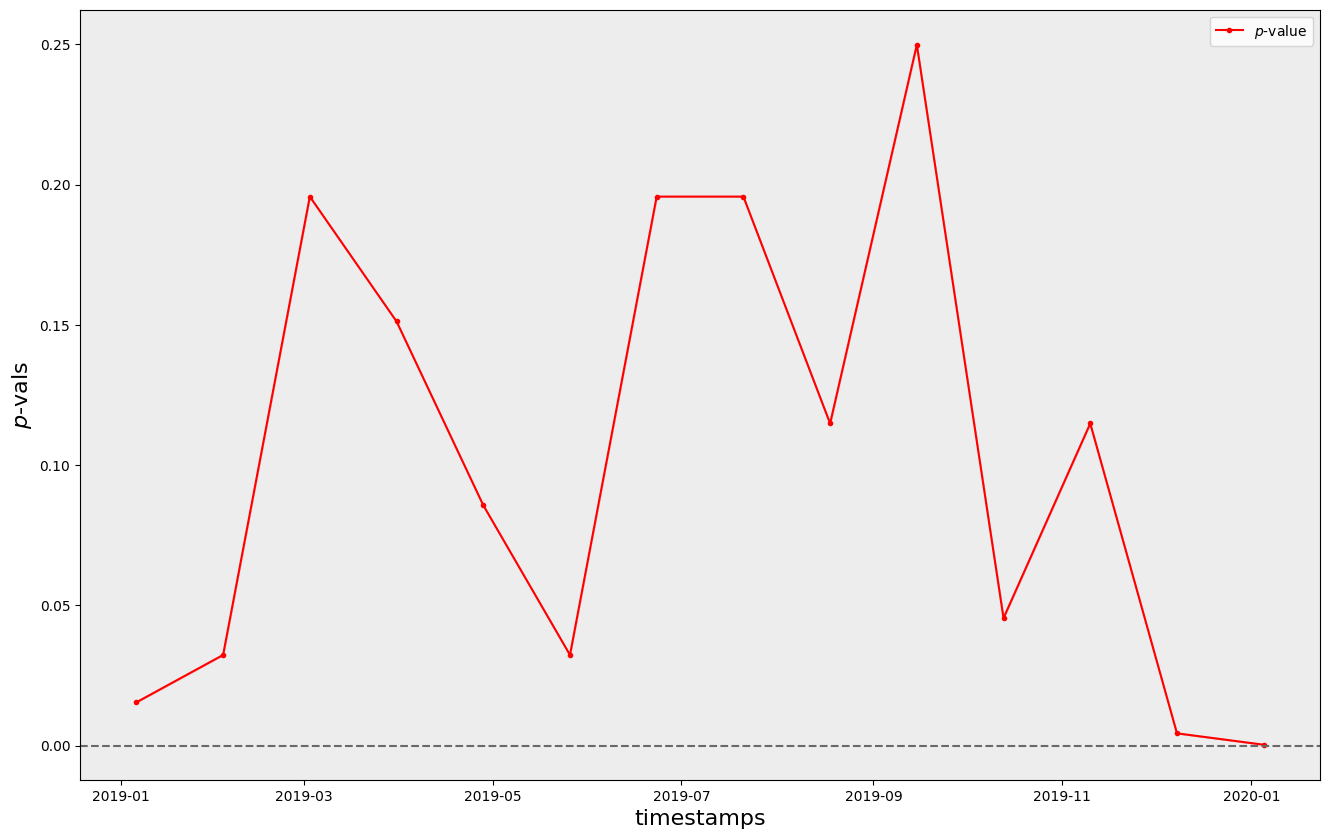

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="ks"),
    source_sample_size=50,
    target_sample_size=10,
    timestamp_column="timestamp",
    window_size="4W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)